In [109]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Blur image, Threshold

In [110]:
def mean_threshold(img, display=True):
    mean = np.mean(img)

    img[img >= mean] = 255
    img[img < mean] = 0

    if display:
        plt.figure(figsize = [10, 10])
        plt.axis('off')
        plt.imshow(img, cmap="gray")

    return img

In [111]:
def threshold(img, threshold=0.5):
    img[img >= threshold] = 1
    img[img < threshold] = 0

    return img
    

In [112]:
def clean_img(img_path):
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
    # clahe = cv2.createCLAHE(clipLimit=200.0, tileGridSize=(4,4))
    # img = clahe.apply(img)

    for _ in range(5):
        img = cv2.blur(img, (10, 10))
        mean_threshold(img)

    return img 

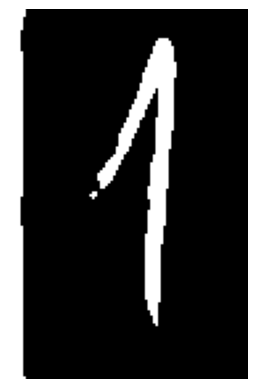

In [113]:
# img = clean_img('../dataset/handwritten_operators/plus/plus 2.png')
plt.axis('off')
plt.imshow(img, cmap='gray')

In [114]:
def adaptive_clean(img_path):
    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

    # Convert to grayscale and apply Otsu's binarization for noise reduction
    # https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(5,5),0)
    _, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    img = 255 - img
    return img


(505, 505)


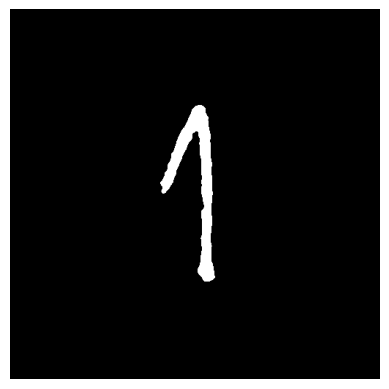

In [123]:
# img = adaptive_clean('../dataset/handwritten_operators/plus/plus 2.png')
# img = adaptive_clean('./slash 2.png')
# img = adaptive_clean('../dataset/4/dataset1_4_11.jpg')
img = adaptive_clean('../test_data/1.png')
print(img.shape)
plt.axis('off')
plt.imshow(img, cmap='gray')

# Center the Image

In [124]:
# img = cv2.imread('./Four_full (16).jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# h, w = img.shape[:2]
# new = np.zeros((h, w, 3), dtype=np.uint8)
# new[:, :, :] = img[:, :, :]

# plt.axis('off')
# plt.imshow(new)

In [125]:
from math import ceil
# Center and square an image
def center_img(img):
    # Getting the contour
    # https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
    # contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)
    # print(hierarchy)
    # M = cv2.moments(contours[0])
    # cv2.drawContours(img, contours, -1, (0,255,0), 15)
    # cX = int(M["m10"] / M["m00"])
    # cY = int(M["m01"] / M["m00"])

    # tX, tY are translations from center of original image to center of character

    # T = np.float32([[1, 0, tX], [0, 1, tY]]) 
    
    # centered = cv2.warpAffine(img, T, (w, h)) 

    # Assuming the image is clean, choose the bounding box for the symbol
    bx, by, bw, bh = cv2.boundingRect(img)
    print(bx, by, bw, bh)

    dim = max(bw, bh) * 1.05 # width of canvas 
    x_tl, y_tl = dim / 1.05 * .025, dim / 1.05 * .025 # top left corner

    dim = ceil(dim)
    x_tl, y_tl = int(x_tl), int(y_tl)
    centered = np.zeros((dim, dim))

    for y in range(by, by + bh):
        for x in range(bx, bx + bw):
            centered[y - by + y_tl][x - bx + x_tl] = img[y][x]
            
    return centered

205 131 75 241


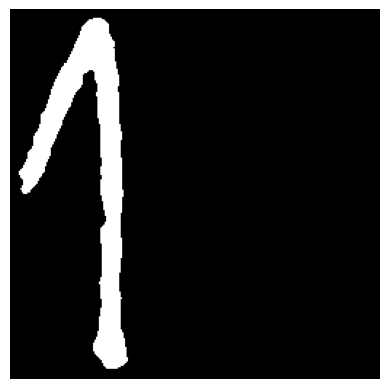

In [126]:
centered = center_img(img)
plt.axis('off')
plt.imshow(centered, cmap='gray')

# Rescale the Image

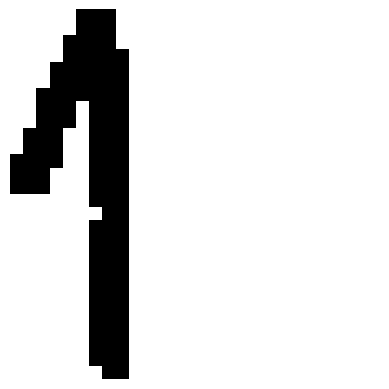

In [128]:
# need similar padding for all images
# same center, scale, thickness

def resize_img(img, dim=28):

    resize = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_AREA)
    # resize = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_CUBIC)

    resize[resize > 0] = 100
    resize[resize < 100] = 255
    resize[resize == 100] = 0

    return resize

resized = resize_img(centered)
plt.axis('off')
plt.imshow(resized, cmap='gray')

# All together

In [150]:
def standardize(img_path):
    img = adaptive_clean(img_path)
    img = center_img(img)
    img = resize_img(img)
    return img

In [133]:
import os
print(os.listdir('../test_data'))

['.DS_Store', '1.png', '10.png', '11.png', '12.png', '13.png', '2.png', '3.png', '4.png', '5.png']


In [153]:
print(np.max(img))

255


205 131 75 241
108 117 247 218
142 205 125 16
145 138 128 132
75 75 133 130
138 105 166 196
151 90 129 248
122 78 141 213
139 99 106 209


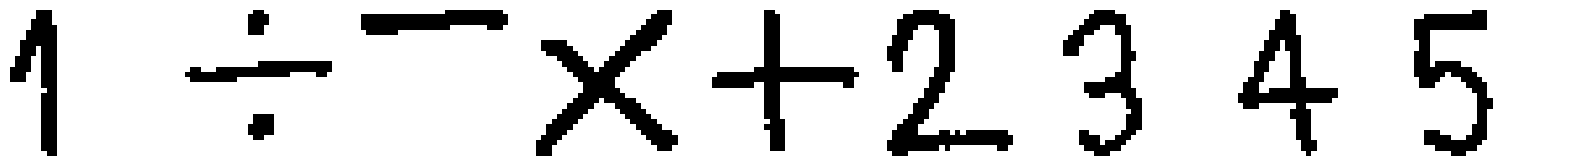

In [154]:
fig = plt.figure(figsize=(20, 10))
i = 0
for image in os.listdir('../test_data/')[1:]:
    resized = standardize(os.path.join('../test_data/', image))
    ax = fig.add_subplot(1, 9, i+1)
    i+=1
    ax.axis('off')
    plt.imshow(resized, cmap='gray')
    plt.imsave("s " + image, resized, cmap='gray')
plt.show()